# Investigate Mapping between Seismic Stations and Boreholes

In [1]:
import geopandas as gpd
import rf
import os
import cartopy.crs as ccrs
from cartopy.geodesic import Geodesic
import matplotlib.pyplot as plt
from shapely import Point
import numpy as np

Load RF data

In [2]:
dataroot = os.path.join("..", "data", "processed")
run = max(
    [
        os.path.join(dataroot, d)
        for d in os.listdir(dataroot)
        if os.path.isdir(os.path.join(dataroot, d))
    ],
    key=os.path.getmtime,
)
stacks = rf.read_rf(os.path.join(run, "rfstacks.h5"), format='h5').sort(["delay","network", "station"])

ValueError: max() arg is an empty sequence

Load boreholedata

In [3]:
dataroot = os.path.join("..", "data", "ABSUC")
boreholes = gpd.read_file(os.path.join(dataroot, "boreholes.geojson"))

/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


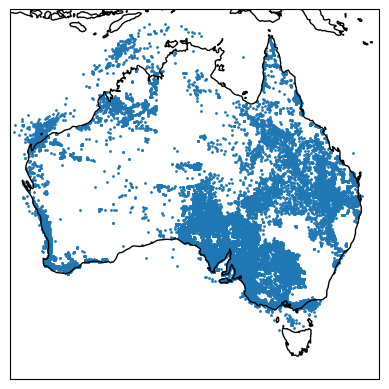

In [4]:
ax = plt.axes(projection=ccrs.Robinson(central_longitude=133))
ax.set_extent([112, 155, -46, -8], ccrs.PlateCarree())
ax.coastlines()

ax.scatter(boreholes.GDA94_LONGITUDE, boreholes.GDA94_LATITUDE, transform=ccrs.PlateCarree(), s=1)

Choose a random point and map polar histogram of borehole counts

/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


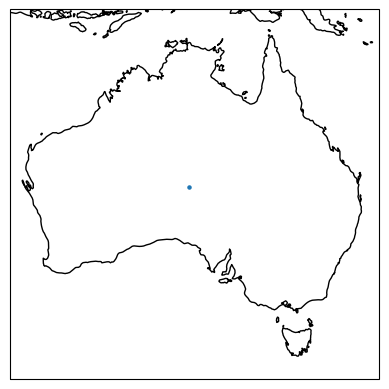

In [19]:
p1 = boreholes.geometry[0]
ax = plt.axes(projection=ccrs.Robinson(central_longitude=133))
ax.set_extent([112, 155, -46, -8], ccrs.PlateCarree())
ax.coastlines()
ax.scatter([p1.x], [p1.y], transform=ccrs.PlateCarree(), s=5)

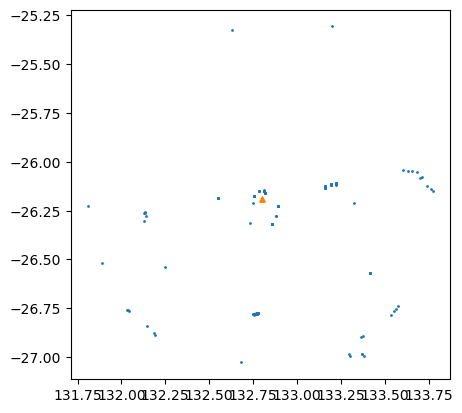

In [20]:
max_dist = 1  # degrees
p1 = boreholes.geometry[0]
dists = p1.distance(boreholes.geometry)
dists = dists[dists <= max_dist]
ax = plt.axes()
boreholes.iloc[dists.index].plot(ax=ax, markersize=1)
ax.scatter([p1.x], [p1.y], s=15, marker="^")

/var/folders/3z/q924mq751jgf5h_73dyy3vx0gyx48k/T/ipykernel_66870/3348734002.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pc = ax.pcolormesh(A, R, hist.T, cmap="magma_r")


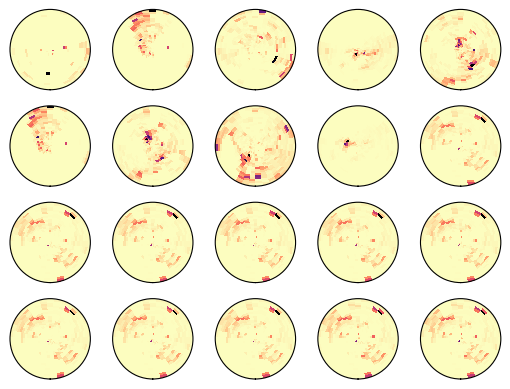

In [25]:
geo = Geodesic()
bh_array = np.array([boreholes.geometry.x, boreholes.geometry.y]).T
max_dist = 1  # degrees
max_dist *= 111  # km
nrows = 145
ncols = 10
w_ratio = nrows / ncols

fig, axs = plt.subplots(145, 10, subplot_kw=dict(projection="polar"), figsize=(20,20))
for ax, p1 in zip(axs.flatten(), boreholes.geometry):
    inv = geo.inverse([p1.x, p1.y], bh_array)
    inv[:, 0] /= 1000
    dists = inv[inv[:, 0] <= max_dist, 0]
    azs = inv[inv[:, 0] <= max_dist, 1]+180
    
    # define binning
    rbins = np.linspace(0, dists.max(), 20)
    abins = np.linspace(0, 2 * np.pi, 36)

    # calculate histogram
    hist, _, _ = np.histogram2d(dists, np.radians(azs), bins=(rbins, abins))
    R, A = np.meshgrid(rbins, abins)

    # plot
    pc = ax.pcolormesh(A, R, hist.T, cmap="magma_r")

    # hack to get the axes and image the right way around
    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    # ax.set_xticklabels(['180°', '225°', '270°', '315°', '0°', '45°', '90°', '135°'])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()
